In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Example: Credit card default prediction

- We want to predict whether a customers will default on their credit card debt based on income, monthly balance, and studentness.

- We model a customer defaulting using the **logistic regression model**:
  $$
  y\sim \operatorname{Bernoulli}\big(\texttt{default}\mid p\big),
  $$
  where
  $$
  \log\left(\frac p{1-p}\right) = a + b\,\texttt{income}+c\,\texttt{balance} + d\,\texttt{student}
  $$


#### Interpreting the coefficient of a binary feature in a logistic regression model

- Odds of defaulting:&nbsp;
  $\displaystyle{{o} = \frac{p}{1-p}}$
- From the logistic regression model:

  $$
  \begin{aligned}
  \log\frac{o_{\text{student}}}
  {o_{\text{nonstudent}}} &=
  \log\left(\frac{p_{\text{student}}}{1-p_{\text{student}}}\right) - \log\left(\frac{p_{\text{nonstudent}}}{1-p_{\text{nonstudent}}}\right)\\
  &= \phantom{-}(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(1))\\&\phantom{=}-(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(0))\\
  &= d\\
  \frac{o_{\text{student}}}{o_{\text{nonstudent}}} &= e^{d}\approx 0.54
  \end{aligned}
  $$

- **_The odds of a student defaulting are roughly half those of a nonstudent with comparable income and balance._**


In [2]:
df = pd.read_csv("../data/Default.csv")
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


In [3]:
X = df[["income", "balance", "student"]]
y = df["default"]
model = LogisticRegression()
model.fit(X, y)

a = model.intercept_
b, c, d = model.coef_.squeeze()

assert np.exp(d).round(2) == 0.54  # See "interpretation" markdown cell.

In [4]:
p = model.predict_proba(X)[:, 1]
all(model.predict(X) == (p >= 0.5))

True

In [5]:
x = pd.DataFrame(
    {
        "income": [10000, 10000],
        "balance": [2000, 2000],
        "student": [1, 0],
    }
)

model.predict(x), model.predict_proba(x)[:, 1]

(array([0, 1]), array([0.49661381, 0.64543196]))

In [6]:
p_student = model.predict_proba(x)[0, 1]
p_nonstudent = model.predict_proba(x)[1, 1]

o_student = p_student / (1 - p_student)
o_nonstudent = p_nonstudent / (1 - p_nonstudent)

assert np.isclose(
    np.log(o_student / o_nonstudent), d
)  # See "interpretation" markdown cell.

- Let's compare risk of default for student versus nonstudent cardholders with incomes of $10000 for a range of balances.

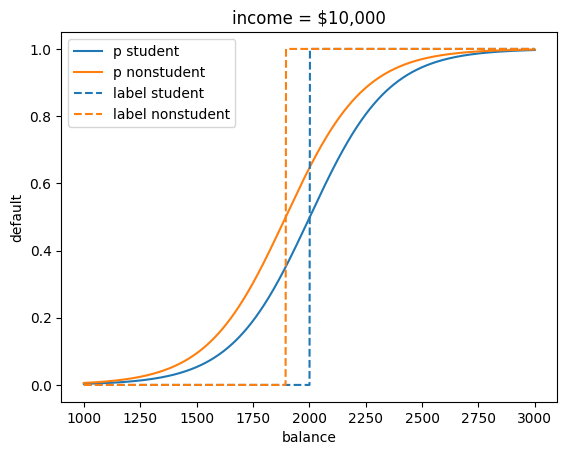

In [7]:
balance = np.linspace(1000, 3000, 1000)

x_student = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [1 for _ in balance],
    }
)

x_nonstudent = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [0 for _ in balance],
    }
)

p_student = model.predict_proba(x_student)[:, 1]
p_nonstudent = model.predict_proba(x_nonstudent)[:, 1]

pred_student = model.predict(x_student)
pred_nonstudent = model.predict(x_nonstudent)

plt.plot(balance, p_student, label="p student")
plt.plot(balance, p_nonstudent, label="p nonstudent")

plt.plot(balance, pred_student, "--C0", label="label student")
plt.plot(balance, pred_nonstudent, "--C1", label="label nonstudent")

plt.xlabel("balance")
plt.ylabel("default")

plt.title("income = $10,000")

plt.legend()
plt.show()

In [8]:
Y = (y.to_numpy().reshape(-1, 1) == np.array([[0, 1]])).astype(int)
log_p = model.predict_log_proba(X)

In [9]:
from sklearn.metrics import log_loss

assert np.isclose(
    -np.sum(Y * log_p, axis=1).mean(), log_loss(y, model.predict_proba(X)[:, 1])
)

### Fake data generation

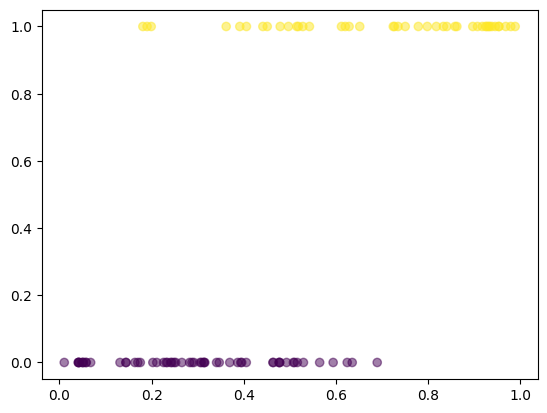

In [10]:
from scipy.special import expit

a = -5
b = 10

rng = np.random.default_rng()


def make_data(n):
    x = rng.uniform(size=n)
    p = expit(a + b * x)
    y = rng.uniform(size=n) < p
    return x, y


x, y = make_data(100)
plt.scatter(x, y, c=y, alpha=0.5)
plt.show()

In [11]:
X = x.reshape(-1, 1)
model = LogisticRegression(max_iter=10000, tol=0.000001, penalty=None)
model.fit(X, y)
ahat, bhat = model.intercept_.item(), model.coef_.item()
ahat, bhat

(-4.188904982391365, 8.05262197321828)

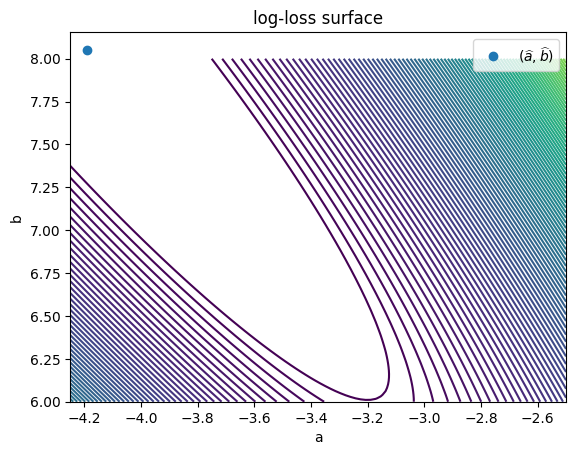

In [12]:
X = x.reshape(-1, 1, 1)
Y = y.astype(int).reshape((-1, 1, 1))

a = np.linspace(-4.25, -2.5, 100)
b = np.linspace(6, 8, 100)
A, B = np.meshgrid(a, b)
P = expit(A + B * X)

# log loss
loss = -np.mean(Y * np.log(P) + (1 - Y) * np.log(1 - P), axis=0)

plt.contour(
    A,
    B,
    loss,
    levels=np.arange(0.395, 0.6, 0.002),
)
plt.plot(ahat, bhat, "o", label="$(\\widehat{{a}}, \\widehat{{b}})$")
plt.xlabel("a")
plt.ylabel("b")
plt.legend()
plt.title("log-loss surface")
plt.show()

In [13]:
import statsmodels.api as sm

In [14]:
X = np.ones((100, 2))
X[:, 1] = x

fit = sm.Logit(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.384401
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                  0.4374
Time:                        12:45:41   Log-Likelihood:                -38.440
converged:                       True   LL-Null:                       -68.331
Covariance Type:            nonrobust   LLR p-value:                 1.059e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1888      0.798     -5.248      0.000      -5.753      -2.624
x1             8.0524      1.544      5.216      0.000       5.027      11.078
==============================================================================
"""

In [15]:
import bambi as bmb
import arviz as az

In [16]:
df = pd.DataFrame({"x": x, "y": y})
model = bmb.Model("y ~ x", df, family="bernoulli")
model

       Formula: y ~ x
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            x ~ Normal(mu: 0.0, sigma: 3.4898)

In [17]:
fit = model.fit()
az.summary(fit)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.756,0.645,-4.970,-2.567,0.01,0.007,4000.0,2892.0,1.0
x,7.165,1.235,4.963,9.525,0.02,0.014,3823.0,2387.0,1.0


In [34]:
df = pd.read_csv("../data/2024CFLScores.csv")
df = df[df["week"].str.startswith("Week")]
df = df[df["host_score"] != df["visitor_score"]]
df

,week,visitor,host,visitor_score,host_score
9,Week 1,MTL,WPG,27,12
10,Week 1,HAM,CGY,24,32
11,Week 1,SSK,EDM,29,21
12,Week 1,BC,TOR,27,35
13,Week 2,WPG,OTT,19,23
...,...,...,...,...,...
85,Week 20,MTL,BC,3,27
86,Week 21,HAM,OTT,31,37
87,Week 21,TOR,EDM,30,31
88,Week 21,WPG,MTL,28,27


In [35]:
teams = set(df["host"])
teams

{'BC', 'CGY', 'EDM', 'HAM', 'MTL', 'OTT', 'SSK', 'TOR', 'WPG'}

In [48]:
y = df["host_score"] > df["visitor_score"]
intercept = pd.Series(np.ones(len(df), dtype=int), index=df.index)
X = pd.DataFrame({"INTERCEPT": intercept})
for team in teams:
    X[team] = (df["host"] == team).astype(int) - (df["visitor"] == team).astype(int)
X

,INTERCEPT,SSK,EDM,HAM,WPG,BC,MTL,TOR,CGY,OTT
9,1,0,0,0,1,0,-1,0,0,0
10,1,0,0,-1,0,0,0,0,1,0
11,1,-1,1,0,0,0,0,0,0,0
12,1,0,0,0,0,-1,0,1,0,0
13,1,0,0,0,-1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
85,1,0,0,0,0,1,-1,0,0,0
86,1,0,0,-1,0,0,0,0,0,1
87,1,0,1,0,0,0,0,-1,0,0
88,1,0,0,0,-1,0,1,0,0,0


In [55]:
fit0 = sm.Logit(y, X).fit()
fit0.summary()

Optimization terminated successfully.
         Current function value: 0.613740
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.08371
Time:                        12:57:25   Log-Likelihood:                -48.485
converged:                       True   LL-Null:                       -52.915
Covariance Type:            nonrobust   LLR p-value:                    0.3543
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTERCEPT      0.4734      0.246      1.922      0.055      -0.009       0.956
SSK            0.0787        nan        nan        nan         nan         nan
EDM           -0.4924        nan        nan        nan         nan         nan
HAM           -0.4264        nan        nan        nan         nan         nan
WPG            0.4531        nan        nan        nan         nan         nan
BC            -0.0182        nan        nan        nan         nan         nan
MTL            0.9042        nan        nan        nan         nan         nan
TOR            0.2482        nan        nan        nan         nan         nan
CGY           -0.9125        nan        nan        nan         nan         nan
OTT            0.1654        nan        nan        nan         nan         nan
==============================================================================
"""

In [70]:
fit0_diffs = np.diff(sorted(fit0.params))
fit0_diffs

array([0.42018679, 0.06594243, 0.40818338, 0.09693025, 0.0866579 ,
       0.08281688, 0.20497082, 0.02024005, 0.43077064])

In [95]:
fit1 = sm.Logit(y, X.drop(columns=["CGY"])).fit()
fit1.summary()

Optimization terminated successfully.
         Current function value: 0.613740
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.08371
Time:                        13:11:00   Log-Likelihood:                -48.485
converged:                       True   LL-Null:                       -52.915
Covariance Type:            nonrobust   LLR p-value:                    0.3543
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTERCEPT      0.4734      0.246      1.922      0.055      -0.009       0.956
SSK            0.9912      0.720      1.377      0.169      -0.420       2.403
EDM            0.4202      0.689      0.610      0.542      -0.929       1.770
HAM            0.4861      0.713      0.682      0.495      -0.911       1.883
WPG            1.3657      0.727      1.877      0.060      -0.060       2.791
BC             0.8943      0.702      1.275      0.202      -0.481       2.270
MTL            1.8167      0.783      2.321      0.020       0.283       3.351
TOR            1.1607      0.720      1.612      0.107      -0.250       2.572
OTT            1.0779      0.732      1.473      0.141      -0.356       2.512
==============================================================================
"""

In [98]:
fit1.params

INTERCEPT    0.473387
SSK          0.991243
EDM          0.420187
HAM          0.486129
WPG          1.365688
BC           0.894313
MTL          1.816699
TOR          1.160718
OTT          1.077901
dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None, tol=0.0000001)
model.fit(X.drop(columns=["INTERCEPT", "CGY"]), y)
coef_ = pd.Series(model.coef_.squeeze(), index=model.feature_names_in_, name="coef_")
print(coef_)
print(model.intercept_.item())

SSK    0.991243
EDM    0.420187
HAM    0.486129
WPG    1.365688
BC     0.894312
MTL    1.816699
TOR    1.160717
OTT    1.077901
Name: coef_, dtype: float64
0.473386920227332


In [121]:
host_victory = df["host_score"] > df["visitor_score"]
X = pd.DataFrame({"host_victory": host_victory})
for team in teams:
    if team != "CGY":
        X[team] = (df["host"] == team).astype(int) - (df["visitor"] == team).astype(int)
X

,host_victory,SSK,EDM,HAM,WPG,BC,MTL,TOR,OTT
9,False,0,0,0,1,0,-1,0,0
10,True,0,0,-1,0,0,0,0,0
11,False,-1,1,0,0,0,0,0,0
12,True,0,0,0,0,-1,0,1,0
13,True,0,0,0,-1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
85,True,0,0,0,0,1,-1,0,0
86,True,0,0,-1,0,0,0,0,1
87,True,0,1,0,0,0,0,-1,0
88,False,0,0,0,-1,0,1,0,0


In [ ]:
model = bmb.Model(
    "host_victory ~ 1 + SSK + EDM + HAM + WPG + BC + MTL + TOR + OTT",
    X,
    family="bernoulli",
)
model

       Formula: host_victory ~ 1 + SSK + EDM + HAM + WPG + BC + MTL + TOR + OTT
        Family: bernoulli
          Link: p = logit
  Observations: 79
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            SSK ~ Normal(mu: 0.0, sigma: 2.1565)
            EDM ~ Normal(mu: 0.0, sigma: 2.095)
            HAM ~ Normal(mu: 0.0, sigma: 2.095)
            WPG ~ Normal(mu: 0.0, sigma: 2.095)
            BC ~ Normal(mu: 0.0, sigma: 2.095)
            MTL ~ Normal(mu: 0.0, sigma: 2.1565)
            TOR ~ Normal(mu: 0.0, sigma: 2.095)
            OTT ~ Normal(mu: 0.0, sigma: 2.1565)

In [129]:
fit = model.fit()

Modeling the probability that host_victory==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, SSK, EDM, HAM, WPG, BC, MTL, TOR, OTT]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [130]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.497,0.252,0.030,0.969,0.004,0.003,3512.0,2817.0,1.0
SSK,0.701,0.639,-0.549,1.851,0.013,0.009,2550.0,3137.0,1.0
EDM,0.116,0.627,-0.970,1.400,0.012,0.008,2853.0,3220.0,1.0
HAM,0.159,0.625,-0.937,1.382,0.012,0.009,2526.0,2707.0,1.0
WPG,1.076,0.638,-0.136,2.251,0.012,0.009,2635.0,2870.0,1.0
BC,0.592,0.634,-0.500,1.845,0.012,0.008,2858.0,3275.0,1.0
MTL,1.516,0.683,0.266,2.812,0.013,0.009,2743.0,2953.0,1.0
TOR,0.861,0.639,-0.340,2.031,0.013,0.009,2590.0,3295.0,1.0
OTT,0.781,0.652,-0.405,2.028,0.012,0.009,2783.0,2656.0,1.0


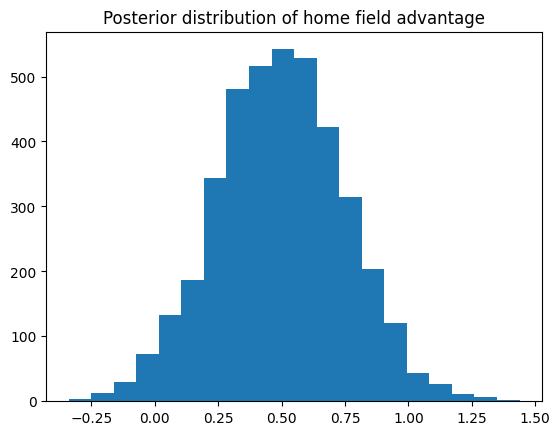

In [147]:
hfa = np.array(fit.posterior.Intercept).ravel()
plt.hist(hfa, bins=20)
plt.title("Posterior distribution of home field advantage")
plt.show()

In [148]:
np.mean(hfa > 0)

0.975

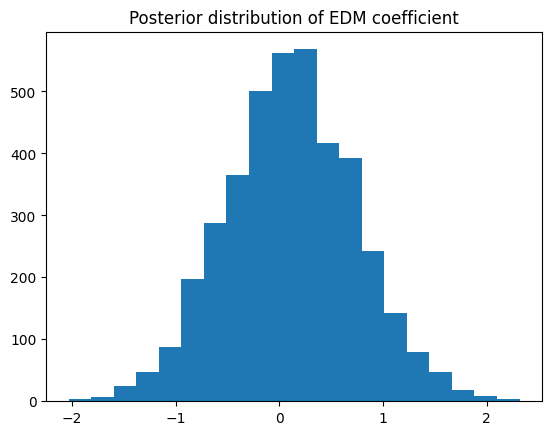

In [ ]:
edm = np.array(fit.posterior.EDM).ravel()
plt.hist(edm, bins=20)
plt.title("Posterior distribution of EDM coefficient")
plt.show()

In [145]:
# What's the probability that EDM is better than CGY?
np.mean(edm > 0)

0.575

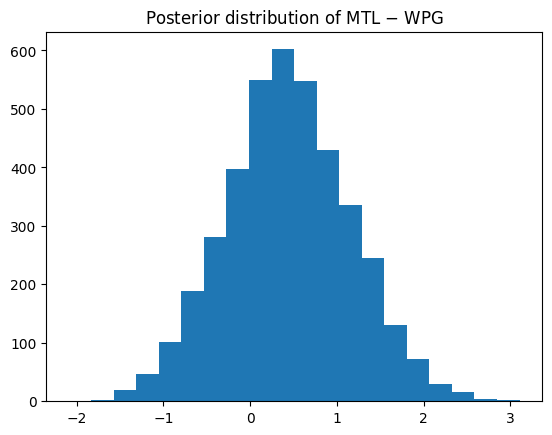

In [159]:
mtl = np.array(fit.posterior.MTL).ravel()
wpg = np.array(fit.posterior.WPG).ravel()

plt.hist(mtl - wpg, bins=20)
plt.title("Posterior distribution of MTL $-$ WPG")
plt.show()

In [157]:
np.mean(mtl > wpg)

0.735

In [156]:
np.mean(mtl > wpg + hfa)

0.469

In [158]:
np.mean(mtl + hfa > wpg)

0.89025

In [166]:
df = bmb.load_data("ANES")
df

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican
...,...,...,...
416,trump,46,independent
417,clinton,64,democrat
418,someone_else,31,independent
419,clinton,39,democrat


In [172]:
pd.crosstab(df["vote"], df["party_id"])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76
